<a href="https://colab.research.google.com/github/elnazsn1988/AIAlpha/blob/master/ALT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MTSS-GAN: Multivariate Time Series Simulation Generative Adversarial Networks

Click here to go back to the GitHub [repo](https://github.com/firmai/mtss-gan). 

##### **Introduction**

MTSS-GAN is a new generative method developed to simulate diverse multivariate time series data with finance applications in mind. The purpose of this synthesiser is two-fold, we both want to generate data that accurately represents the original data, while also having the flexibility to generate new data with novel and unique relationships that could help with model testing and robustness checks. The method is inspired by stacked GANs originally designed for image generation. Stacked GANs have produced some of the best quality images, for that reason MTSS-GAN is expected to be a leading contender in multivariate time series generation.


In this paper we propose a framework of two network encoders, two generators and two discriminators locked into two adversarial models. The framework has the flexibility to branch out to include additional targeted conditional features. Each additional feature layer will require an additional encoder, generator, and discriminator layer. At the end we discard all the models except the two generators; the one feeds into the other to generate the final synthetic dataset.

Simple conditional GANs allow us to generate specific outputs using noise code and one-hot labels as input (Mirza & Osindero, 2014). The benefit of MTSS-GAN over conditional GAN's is that the adjustments can be made both with one-hot labels and disentangled latent code . There has been research looking into conditional univariate simulations in finance, but not yet for conditional multivariate simulations (Fu et al., 2019). 

There has also been synthesisers developed in the medical community to develop conditional multivariate simulation, but without the flexibility afforded by using disentangled latent code (Esteban et al., 2017). Disentangled code is beneficial because you can change specific attributes while not affecting other attributes. This is possible because the disentangled code is in-fact inputs to network encoders or outputs from network encoder and acts more like features than gaussian noise.  

MTSS-GAN uses a pretrained encoder classifier to disentangle latent codes. MTSS-GAN is a stack of models each with an encoder and a GAN similar to the stacked GAN framework for image generation (Huang et al., 2017). Each GAN is trained in an adversarial manner by using the input and output data of the corresponding encoder . MTSS-GANs can also be stacked to allow for various types of features, but even when this is not done, disentangled code can still be adjusted and the effect on generated data can be recoded.

If, for example, a normal GAN uses 200-dimensional noise code, then all the features are entangled within these dimensions; the salient attributes are not disentangled. With MTSS-GAN we separate the code into entangle and disentangled interpretable latent code to teach the generator what to synthesise. The n-dimensional entangled code is still necessary to represent all the attributes that have not been disentangled. Each GAN is trained independently in the usual discriminator-adversarial manner with its own latent code. 



Please see the [paper](http://ssrn.com/abstract=3616557) for futher description.

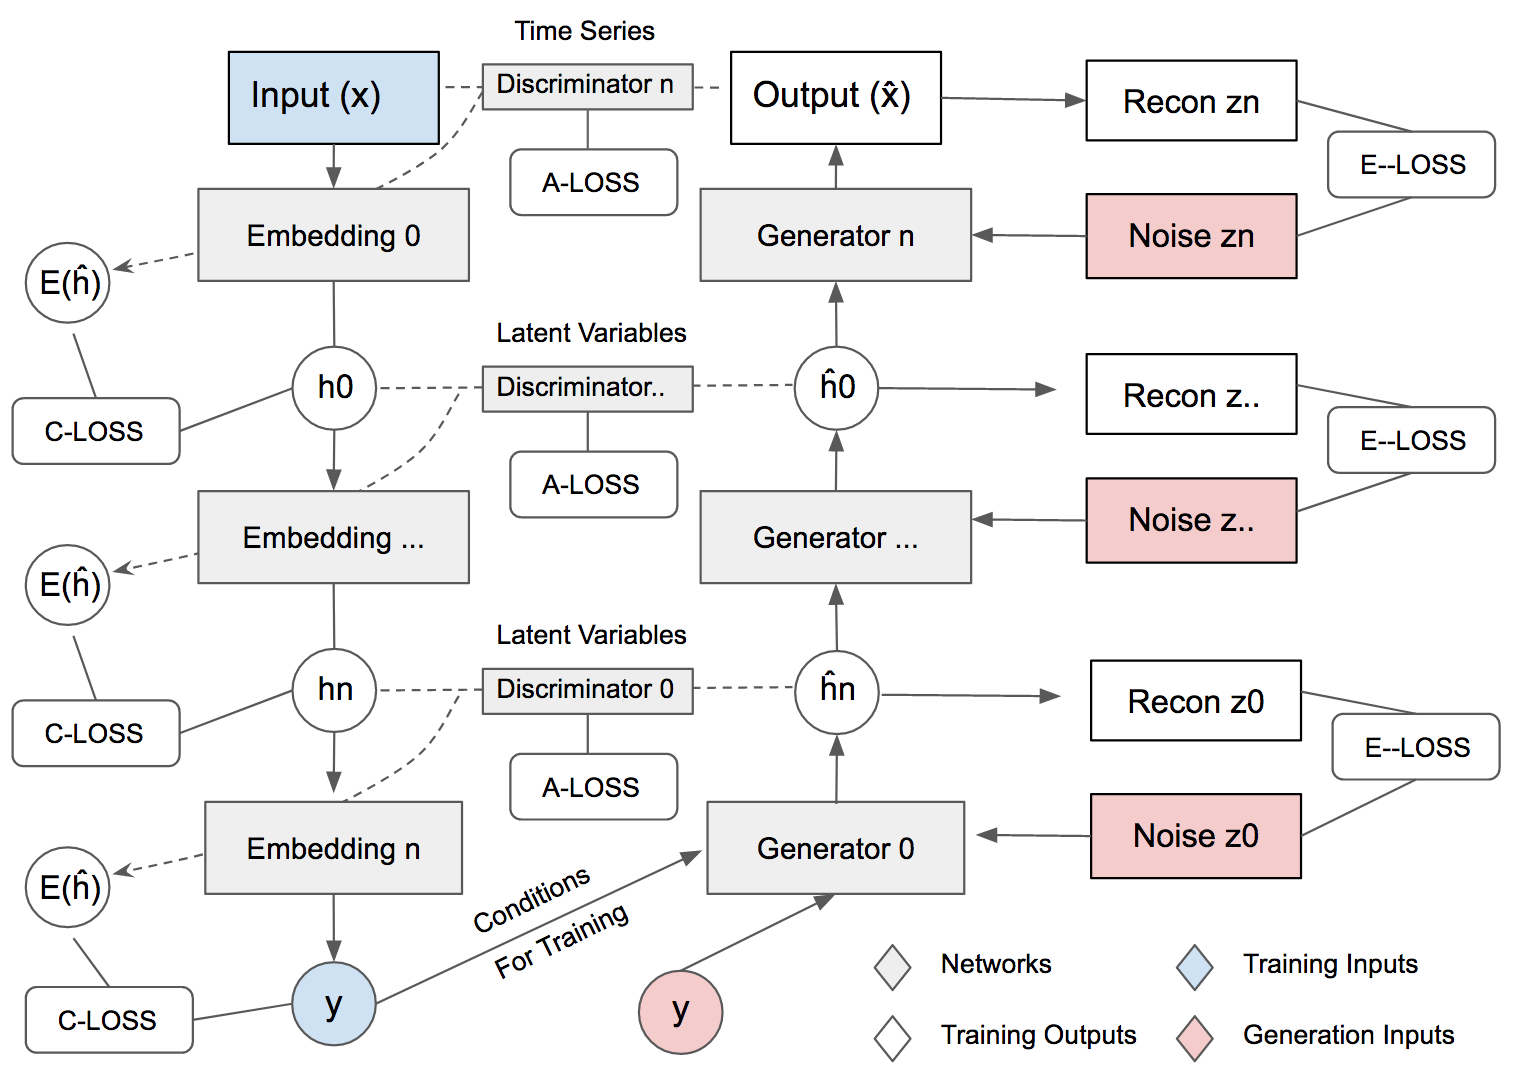

In [0]:
%%capture
!pip install tensorview 

Mount a drive to permenantly save and retrieve models. You can skip this if you are running the model from scratch.

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd "/content/drive/My Drive/FirmAI/DataGene/model"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/FirmAI/DataGene/model


In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
"""
### This section of the code is derived from 
Yoon, J., Jarrett, D., & van der Schaar, M. (2019). 
Time-series Generative Adversarial Networks. 
Advances in Neural Information Processing Systems, 5509–5519.
you can find my fork of their code here: https://github.com/firmai/tsgan

"""

#%% PCA Analysis
    
def PCA_Analysis (dataX, dataX_hat):
  
    # Analysis Data Size
    Sample_No = min(len(dataX)-100, len(dataX_hat)-100)
    
    # Data Preprocessing
    for i in range(Sample_No):
        if (i == 0):
            arrayX = np.reshape(np.mean(np.asarray(dataX[0]),1), [1,len(dataX[0][:,0])])
            arrayX_hat = np.reshape(np.mean(np.asarray(dataX_hat[0]),1), [1,len(dataX[0][:,0])])
        else:
            arrayX = np.concatenate((arrayX, np.reshape(np.mean(np.asarray(dataX[i]),1), [1,len(dataX[0][:,0])])))
            arrayX_hat = np.concatenate((arrayX_hat, np.reshape(np.mean(np.asarray(dataX_hat[i]),1), [1,len(dataX[0][:,0])])))
    
    # Parameters        
    No = len(arrayX[:,0])
    colors = ["red" for i in range(No)] +  ["blue" for i in range(No)]    
    
    # PCA Analysis
    pca = PCA(n_components = 2)
    pca.fit(arrayX)
    pca_results = pca.transform(arrayX)
    pca_hat_results = pca.transform(arrayX_hat)
        
    # Plotting
    f, ax = plt.subplots(1)
    
    plt.scatter(pca_results[:,0], pca_results[:,1], c = colors[:No], alpha = 0.2, label = "Original")
    plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], c = colors[No:], alpha = 0.2, label = "Synthetic")

    ax.legend()
    
    plt.title('PCA plot')
    plt.xlabel('x-pca')
    plt.ylabel('y_pca')
    plt.show()
    
    
#%% TSNE Analysis
    
def tSNE_Analysis (dataX, dataX_hat):
  
    # Analysis Data Size
    Sample_No = min(len(dataX)-100, len(dataX_hat)-100)
  
    # Preprocess
    for i in range(Sample_No):
        if (i == 0):
            arrayX = np.reshape(np.mean(np.asarray(dataX[0]),1), [1,len(dataX[0][:,0])])
            arrayX_hat = np.reshape(np.mean(np.asarray(dataX_hat[0]),1), [1,len(dataX[0][:,0])])
        else:
            arrayX = np.concatenate((arrayX, np.reshape(np.mean(np.asarray(dataX[i]),1), [1,len(dataX[0][:,0])])))
            arrayX_hat = np.concatenate((arrayX_hat, np.reshape(np.mean(np.asarray(dataX_hat[i]),1), [1,len(dataX[0][:,0])])))
     
    # Do t-SNE Analysis together       
    final_arrayX = np.concatenate((arrayX, arrayX_hat), axis = 0)
    
    # Parameters
    No = len(arrayX[:,0])
    colors = ["red" for i in range(No)] +  ["blue" for i in range(No)]    
    
    # TSNE anlaysis
    tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
    tsne_results = tsne.fit_transform(final_arrayX)
    
    # Plotting
    f, ax = plt.subplots(1)
    
    plt.scatter(tsne_results[:No,0], tsne_results[:No,1], c = colors[:No], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[No:,0], tsne_results[No:,1], c = colors[No:], alpha = 0.2, label = "Synthetic")

    ax.legend()
    
    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()

Here are two condition recipes to create labels that will be used in the encoding step. In this example, we will use ```end_cond```, which looks at the percentage difference in price from the opening to the closing data. Every dataset will have its own conditions. The conditions here look at moving averages, return percentages, and volatility. 

In [0]:
import pandas as pd
import tensorview as tv

def labels(url):
  stock = pd.read_csv(url)

  rolling_20_mean = stock.Close.rolling(window=20).mean()[50:]
  rolling_50_mean = stock.Close.rolling(window=50).mean()[50:]
  rolling_50_std = stock.Close.rolling(window=50).std()[50:]

  stock = stock.iloc[50:,:]

  cond_0 = np.where((stock["Close"]<rolling_20_mean) & (stock["Close"]<rolling_50_mean)& (rolling_50_std>rolling_50_std.median()),1,0)
  cond_1 = np.where((stock["Close"]>rolling_20_mean) & (stock["Close"]<rolling_50_mean)& (rolling_50_std>rolling_50_std.median()),2,0)
  cond_2 = np.where((stock["Close"]>rolling_20_mean) & (stock["Close"]>rolling_50_mean)& (rolling_50_std>rolling_50_std.median()),3,0)
  cond_3 = np.where((stock["Close"]>rolling_20_mean) & (stock["Close"]>rolling_50_mean)& (rolling_50_std<rolling_50_std.median()),4,0)
  cond_4 = np.where((stock["Close"]<rolling_20_mean) & (stock["Close"]>rolling_50_mean)& (rolling_50_std<rolling_50_std.median()),5,0)
  cond_5 = np.where((stock["Close"]>rolling_20_mean) & (stock["Close"]<rolling_50_mean)& (rolling_50_std<rolling_50_std.median()),6,0)

  cond_all = cond_0 + cond_1 + cond_2+ cond_3+ cond_4+ cond_5
  stock["Label"] = cond_all
  
  return stock

def end_cond(X_train):
  vals = X_train[:,23,4]/X_train[:,0,4]-1

  comb1 = np.where(vals<-.1,0,0)
  comb2 = np.where((vals>=-.1)&(vals<=-.05),1,0)
  comb3 = np.where((vals>=-.05)&(vals<=-.0),2,0)
  comb4 = np.where((vals>0)&(vals<=0.05),3,0)
  comb5 = np.where((vals>0.05)&(vals<=0.1),4,0)
  comb6 = np.where(vals>0.1,5,0)
  cond_all = comb1 + comb2 + comb3+ comb4+ comb5+ comb6

  print(np.unique(cond_all, return_counts=True))
  arr = np.repeat(cond_all,24, axis=0).reshape(len(cond_all),24)
  X_train = np.dstack((X_train, arr))
  return X_train

Here we load and preprocess the data as well as specify certain parameters needed for the rest of the training.

In [0]:
#%% Necessary Packages
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def MinMax(train_data):
  scaler = MinMaxScaler()
  num_instances, num_time_steps, num_features = train_data.shape
  train_data = np.reshape(train_data, (-1, num_features))
  train_data = scaler.fit_transform(train_data)
  train_data = np.reshape(train_data, (num_instances, num_time_steps, num_features))
  return train_data, scaler

#%% Load Google Data
    
def google_data_loading(seq_length):

    # Load Google Data
    x = np.loadtxt('https://github.com/firmai/tsgan/raw/master/alg/timegan/data/GOOGLE_BIG.csv', delimiter = ",",skiprows = 1)
    #x = labels("https://github.com/firmai/tsgan/raw/master/alg/timegan/data/GOOGLE_BIG.csv")
    x = np.array(x)

    # Build dataset
    dataX = []
    
    # Cut data by sequence length
    for i in range(0, len(x) - seq_length):
        _x = x[i:i + seq_length]
        dataX.append(_x)
        
    # Mix Data (to make it similar to i.i.d)
    idx = np.random.permutation(len(dataX))
    
    outputX = []
    for i in range(len(dataX)):
        outputX.append(dataX[idx[i]])
    
    X_train = np.stack(dataX)

    X_train = end_cond(X_train) #Adding the conditions

    x_x, scaler = MinMax(X_train[:,:,:-1])

    #x_x = np.c_[x_x, X_train[:,:,-1]]
    x_x = np.dstack((x_x, X_train[:,:,-1]))

    return x_x, X_train, scaler


seq_length = 24 #specifying the lenght of series

dataX, X_train, scaler = google_data_loading(seq_length)

features_n = 6

noise_dim = seq_length*features_n
SHAPE = (seq_length, features_n)
hidden_dim = features_n*4

(array([0, 1, 2, 3, 4, 5]), array([255, 449, 764, 957, 617, 619]))


In [0]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv1D, Conv2D, Flatten, GRU
from tensorflow.keras.layers import Reshape, Conv2DTranspose, UpSampling1D
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate, Flatten
from tensorflow.keras.models import Model
import numpy as np
import math
import matplotlib.pyplot as plt
import os

"""Model Design
The archeticture closely follows Huang, X., Li, Y., Poursaeed, O., Hopcroft, J., 
& Belongie, S. (2017). Stacked generative adversarial networks. 

The stacked GAN implementation by Atienza, Rowel has been invaluable:
Advanced Deep Learning with Keras: Apply deep learning techniques, autoencoders, GANs, variational autoencoders, deep 
reinforcement learning, policy gradients, and more. Packt Publishing Ltd, 2018.

"""

def generator(inputs,
              activation='sigmoid',
              labels=None,
              codes=None):
    """Build a Generator Model
    Output activation is sigmoid instead of tanh in as Sigmoid converges easily.
    [1] Radford, Alec, Luke Metz, and Soumith Chintala.
    "Unsupervised representation learning with deep convolutional
    generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015)..
    Arguments:
        inputs (Layer): Input layer of the generator (the z-vector)
        activation (string): Name of output activation layer
        codes (list): 2-dim disentangled codes
    Returns:
        Model: Generator Model
    """

    if codes is not None:
        # generator 0 of MTSS
        inputs = [inputs, codes]
        x = concatenate(inputs, axis=1)
        # noise inputs + conditional codes
    else:
        # default input is just a noise dimension (z-code)
        x = inputs ## 

    x = Dense(SHAPE[0]*SHAPE[1])(x)
    x = Reshape((SHAPE[0], SHAPE[1]))(x)
    x = GRU(72, return_sequences=False, return_state=False,unroll=True)(x)
    x = Reshape((int(SHAPE[0]/2), 6))(x)
    x = Conv1D(128, 4, 1, "same")(x)
    x = BatchNormalization(momentum=0.8)(x) # adjusting and scaling the activations
    x = ReLU()(x)
    x = UpSampling1D()(x)
    x = Conv1D(6, 4, 1, "same")(x)
    x = BatchNormalization(momentum=0.8)(x)

    if activation is not None:
        x = Activation(activation)(x)

    # generator output is the synthesized data x
    return Model(inputs, x,  name='gen1')



def discriminator(inputs,
                  activation='sigmoid',
                  num_labels=None,
                  num_codes=None):
    """Build a Discriminator Model
    The network does not converge with batch normalisation so it is not used here
    Arguments:
        inputs (Layer): Input layer of the discriminator (the sample)
        activation (string): Name of output activation layer
        num_codes (int): num_codes-dim Q network as output 
                    if MTSS-GAN or 2 Q networks if InfoGAN
                    
    Returns:
        Model: Discriminator Model
    """
    ints = int(SHAPE[0]/2)
    x = inputs
    x = GRU(SHAPE[1]*SHAPE[0] , return_sequences=False, return_state=False,unroll=True, activation="relu")(x)
    x = Reshape((ints, ints))(x)
    x = Conv1D(16, 3,2, "same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv1D(32, 3, 2, "same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv1D(64, 3, 2, "same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv1D(128, 3, 1, "same")(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    # default output is probability that the time series array is real
    outputs = Dense(1)(x)

    if num_codes is not None:
        # MTSS-GAN Q0 output
        # z0_recon is reconstruction of z0 normal distribution
        # eventually two loss functions from this output.
        z0_recon =  Dense(num_codes)(x)
        z0_recon = Activation('tanh', name='z0')(z0_recon)
        outputs = [outputs, z0_recon]

    return Model(inputs, outputs, name='discriminator')


In [0]:
'''MTSSGAN uses Encoders, Generators and Discriminators.
The encoder is a label classifier as well as a means to obtain latent
features and labels that the generator learns by inverting the process. 
The generator uses conditioning labels and latent codes
(z0 and z1) to synthesize time series data by fooling the discriminator.
The labels, z0 and z1 are disentangled codes used to control 
the attributes of synthesized time series data. The discriminator determines 
if the data and feature1 features are real or fake. At the same time,
it estimates the latent codes that generated the sample and feature1 features.

[1] Radford, Alec, Luke Metz, and Soumith Chintala.
"Unsupervised representation learning with deep convolutional
generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).
[2] Huang, Xun, et al. "Stacked generative adversarial networks." 
IEEE Conference on Computer Vision and Pattern Recognition (CVPR). 
Vol. 2. 2017.
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import concatenate

import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse

import sys
sys.path.append("..")
#from lib import gan

def build_encoder(inputs, num_labels=6, feature0_dim=6*24):
    """ Build the Classifier (Encoder) Model sub networks
    Two sub networks: 
    1) Encoder0: time series array to feature0 (intermediate latent feature)
    2) Encoder1: feature0 to labels
    # Arguments
        inputs (Layers): x - time series array, feature1 - 
            feature1 layer output
        num_labels (int): number of class labels
        feature0_dim (int): feature0 dimensionality
    # Returns
        enc0, enc1 (Models): Description below 
    """


    x, feature0 = inputs

    y = GRU(SHAPE[0]*SHAPE[1], return_sequences=False, return_state=False,unroll=True)(x)
    y = Flatten()(y)
    feature0_output = Dense(feature0_dim, activation='relu')(y)
    # Encoder0 or enc0: data to feature0 
    enc0 = Model(inputs=x, outputs=feature0_output, name="encoder0")
    
    # Encoder1 or enc1
    y = Dense(num_labels)(feature0)
    labels = Activation('softmax')(y)
    # Encoder1 or enc1: feature0 to class labels 
    enc1 = Model(inputs=feature0, outputs=labels, name="encoder1")

    # return both enc0 and enc1
    return enc0, enc1


def build_generator(latent_codes, feature0_dim=144):
    """Build Generator Model sub networks
    Two sub networks: 1) Class and noise to feature0 
        (intermediate feature)
        2) feature0 to time series array
    # Arguments
        latent_codes (Layers): dicrete code (labels),
            noise and feature0 features
        feature0_dim (int): feature0 dimensionality
    # Returns
        gen0, gen1 (Models): Description below
    """

    # Latent codes and network parameters
    labels, z0, z1, feature0 = latent_codes

    # gen0 inputs
    inputs = [labels, z0]      # 6 + 50 = 62-dim
    x = concatenate(inputs, axis=1)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    fake_feature0 = Dense(feature0_dim, activation='relu')(x)

    # gen0: classes and noise (labels + z0) to feature0
    gen0 = Model(inputs, fake_feature0, name='gen0')


    # gen1: feature0 + z0 to feature1 (time series array)
    # example: Model([feature0, z0], (steps, feats),  name='gen1')
    gen1 = generator(feature0, codes=z1)

    return gen0, gen1


def build_discriminator(inputs, z_dim=50):
    """Build Discriminator 1 Model
    Classifies feature0 (features) as real/fake time series array and recovers
    the input noise or latent code (by minimizing entropy loss)
    # Arguments
        inputs (Layer): feature0
        z_dim (int): noise dimensionality
    # Returns
        dis0 (Model): feature0 as real/fake recovered latent code
    """

    # input is 256-dim feature1
    x = Dense(SHAPE[0]*SHAPE[1], activation='relu')(inputs)
  
    x = Dense(SHAPE[0]*SHAPE[1], activation='relu')(x)


    # first output is probability that feature0 is real
    f0_source = Dense(1)(x)
    f0_source = Activation('sigmoid',
                           name='feature1_source')(f0_source)

    # z0 reonstruction (Q0 network)
    z0_recon = Dense(z_dim)(x) 
    z0_recon = Activation('tanh', name='z0')(z0_recon)
    
    discriminator_outputs = [f0_source, z0_recon]
    dis0 = Model(inputs, discriminator_outputs, name='dis0')
    return dis0


def train(models, data, params):
    """Train the discriminator and adversarial Networks
    Alternately train discriminator and adversarial networks by batch.
    Discriminator is trained first with real and fake time series array,
    corresponding one-hot labels and latent codes.
    Adversarial is trained next with fake time series array pretending
    to be real, corresponding one-hot labels and latent codes.
    Generate sample time series data per save_interval.
    # Arguments
        models (Models): Encoder, Generator, Discriminator,
            Adversarial models
        data (tuple): x_train, y_train data
        params (tuple): Network parameters
    """
    # the MTSS-GAN and Encoder models

    enc0, enc1, gen0, gen1, dis0, dis1, adv0, adv1 = models
    # network parameters
    batch_size, train_steps, num_labels, z_dim, model_name = params
    # train dataset
    (x_train, y_train), (_, _) = data # I can do this. 
    # the generated time series array is saved every 500 steps
    save_interval = 500

    # label and noise codes for generator testing
    z0 = np.random.normal(scale=0.5, size=[SHAPE[0], z_dim])
    z1 = np.random.normal(scale=0.5, size=[SHAPE[0], z_dim])
    noise_class = np.eye(num_labels)[np.arange(0, SHAPE[0]) % num_labels]
    noise_params = [noise_class, z0, z1]
    # number of elements in train dataset
    train_size = x_train.shape[0]
    print(model_name,
          "Labels for generated time series arrays: ",
          np.argmax(noise_class, axis=1))

    tv_plot = tv.train.PlotMetrics(columns=5, wait_num=5)
    for i in range(train_steps):
        # train the discriminator1 for 1 batch
        # 1 batch of real (label=1.0) and fake feature1 (label=0.0)
        # randomly pick real time series arrays from dataset
        dicta = {}
        rand_indexes = np.random.randint(0, 
                                         train_size, 
                                         size=batch_size)
        real_samples = x_train[rand_indexes]
        # real feature1 from encoder0 output
        real_feature0 = enc0.predict(real_samples)
        # generate random 50-dim z1 latent code
        real_z0 = np.random.normal(scale=0.5,
                                   size=[batch_size, z_dim])
        # real labels from dataset
        real_labels = y_train[rand_indexes]

        # generate fake feature1 using generator1 from
        # real labels and 50-dim z1 latent code
        fake_z0 = np.random.normal(scale=0.5,
                                   size=[batch_size, z_dim])
        fake_feature0 = gen0.predict([real_labels, fake_z0])

        # real + fake data
        feature0 = np.concatenate((real_feature0, fake_feature0))
        z0 = np.concatenate((fake_z0, fake_z0))

        # label 1st half as real and 2nd half as fake
        y = np.ones([2 * batch_size, 1])
        y[batch_size:, :] = 0

        # train discriminator1 to classify feature1 as 
        # real/fake and recover
        # latent code (z0). real = from encoder1, 
        # fake = from genenerator10
        # joint training using discriminator part of 
        # advserial1 loss and entropy0 loss
        metrics = dis0.train_on_batch(feature0, [y, z0])
        # log the overall loss only
        log = "%d: [dis0_loss: %f]" % (i, metrics[0])
        dicta["dis0_loss"] = metrics[0]
         
        # train the discriminator1 for 1 batch
        # 1 batch of real (label=1.0) and fake time series arrays (label=0.0)
        # generate random 50-dim z1 latent code
        fake_z1 = np.random.normal(scale=0.5, size=[batch_size, z_dim])
        # generate fake time series arrays from real feature1 and fake z1
        fake_samples = gen1.predict([real_feature0, fake_z1])
       
        # real + fake data
        x = np.concatenate((real_samples, fake_samples))
        z1 = np.concatenate((fake_z1, fake_z1))

        # train discriminator1 to classify time series arrays 
        # as real/fake and recover latent code (z1)
        # joint training using discriminator part of advserial0 loss
        # and entropy1 loss
        metrics = dis1.train_on_batch(x, [y, z1])
        # log the overall loss only (use dis1.metrics_names)
        log = "%s [dis1_loss: %f]" % (log, metrics[0])
        dicta["dis1_loss"] = metrics[0]

        # adversarial training 
        # generate fake z0, labels
        fake_z0 = np.random.normal(scale=0.5, 
                                   size=[batch_size, z_dim])
        # input to generator0 is sampling fr real labels and
        # 50-dim z0 latent code
        gen0_inputs = [real_labels, fake_z0]

        # label fake feature0 as real (specifies whether real or not)
        # is it bypassing the discriminator?
        y = np.ones([batch_size, 1])
    
        # train generator0 (thru adversarial) by fooling 
        # the discriminator
        # and approximating encoder1 feature0 generator
        # joint training: adversarial0, entropy0, conditional0
        metrics = adv0.train_on_batch(gen0_inputs,
                                      [y, fake_z0, real_labels])
        fmt = "%s [adv0_loss: %f, enc1_acc: %f]"
        dicta["adv0_loss"] = metrics[0]
        dicta["enc1_acc"] = metrics[6]

        # log the overall loss and classification accuracy
        log = fmt % (log, metrics[0], metrics[6])

        # input to generator0 is real feature0 and 
        # 50-dim z0 latent code
        fake_z1 = np.random.normal(scale=0.5,
                                   size=[batch_size, z_dim])
        
        gen1_inputs = [real_feature0, fake_z1]

        # train generator1 (thru adversarial) by fooling 
        # the discriminator and approximating encoder1 time series arrays 
        # source generator joint training: 
        # adversarial1, entropy1, conditional1
        metrics = adv1.train_on_batch(gen1_inputs,
                                      [y, fake_z1, real_feature0])
        # log the overall loss only
        log = "%s [adv1_loss: %f]" % (log, metrics[0])
        dicta["adv1_loss"] = metrics[0]


        print(log)
        if (i + 1) % save_interval == 0:
            generators = (gen0, gen1)
            plot_ts(generators,
                        noise_params=noise_params,
                        show=False,
                        step=(i + 1),
                        model_name=model_name)
            
        tv_plot.update({'dis0_loss': dicta["dis0_loss"], 'dis1_loss': dicta["dis1_loss"], 'adv0_loss': dicta["adv0_loss"], 'enc1_acc': dicta["enc1_acc"], 'adv1_loss': dicta["adv1_loss"]})
        tv_plot.draw()

    # save the modelis after training generator0 & 1
    # the trained generator can be reloaded for
    # future data generation
    gen0.save(model_name + "-gen1.h5")
    gen1.save(model_name + "-gen0.h5")

    return  gen0, gen1 
    

def plot_ts(generators,
                noise_params,
                show=False,
                step=0,
                model_name="gan"):
    """Generate fake time series arrays and plot them
    For visualization purposes, generate fake time series arrays
    then plot them in a square grid
    # Arguments
        generators (Models): gen0 and gen1 models for 
            fake time series arrays generation
        noise_params (list): noise parameters 
            (label, z0 and z1 codes)
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save time series arrays
        model_name (string): Model name
    """

    gen0, gen1 = generators
    noise_class, z0, z1 = noise_params
    feature0 = gen0.predict([noise_class, z0])
    tss = gen1.predict([feature0, z1])


def train_encoder(model,
                  data, 
                  model_name="MTSS-GAN", 
                  batch_size=64):
    """ Train the Encoder Model (enc0 and enc1)
    # Arguments
        model (Model): Encoder
        data (tensor): Train and test data
        model_name (string): model name
        batch_size (int): Train batch size
    """

    (x_train, y_train), (x_test, y_test) = data
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.fit(x_train,
              y_train,
              validation_data=(x_test, y_test),
              epochs=10,
              batch_size=batch_size)

    model.save(model_name + "-encoder.h5")
    score = model.evaluate(x_test,
                           y_test, 
                           batch_size=batch_size,
                           verbose=0)
    print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))




def build_and_train_models(train_steps = 2000):
    """Load the dataset, build MTSS discriminator,
    generator, and adversarial models.
    Call the MTSS train routine.
    """

    dataX, _, _ = google_data_loading(seq_length)
    dataX = np.stack(dataX)

    train_n = int(len(dataX)*.70)
    X = dataX[:,:,:-1]
    y = dataX[:,-1,-1]
    x_train, y_train = X[:train_n,:,:], y[:train_n]
    x_test, y_test = X[train_n:,:,:], y[train_n:]

    # number of labels
    num_labels = len(np.unique(y_train))
    # to one-hot vector
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    model_name = "MTSS-GAN"
    # network parameters
    batch_size = 64
    #train_steps = 10
    #train_steps = 2000

    lr = 2e-4
    decay = 6e-8
    z_dim = 50 ##this is the real noise input
    z_shape = (z_dim, )
    feature0_dim = SHAPE[0]*SHAPE[1]
    feature0_shape = (feature0_dim, )
    # [1] uses Adam, but discriminator converges easily with RMSprop
    optimizer = RMSprop(lr=lr, decay=decay)

    # build discriminator 0 and Q network 0 models
    input_shape = (feature0_dim, )
    inputs = Input(shape=input_shape, name='discriminator0_input')
    dis0 = build_discriminator(inputs, z_dim=z_dim )
    #Model(Dense(SHAPE[0]*SHAPE[1]), [f0_source, z0_recon], name='dis0')

    # loss fuctions: 1) probability feature0 is real 
    # (adversarial0 loss)
    # 2) MSE z0 recon loss (Q0 network loss or entropy0 loss)
    # Because there are two outputs. 

    loss = ['binary_crossentropy', 'mse']
    loss_weights = [1.0, 1.0] 
    dis0.compile(loss=loss,
                 loss_weights=loss_weights,
                 optimizer=optimizer,
                 metrics=['accuracy'])
    dis0.summary() # feature0 discriminator, z0 estimator

    # build discriminator 1 and Q network 1 models

    input_shape = (x_train.shape[1], x_train.shape[2])
    inputs = Input(shape=input_shape, name='discriminator1_input')
    dis1 = discriminator(inputs, num_codes=z_dim)

    # loss fuctions: 1) probability time series arrays is real (adversarial1 loss)
    # 2) MSE z1 recon loss (Q1 network loss or entropy1 loss)
    loss = ['binary_crossentropy', 'mse']
    loss_weights = [1.0, 10.0] 
    dis1.compile(loss=loss,
                 loss_weights=loss_weights,
                 optimizer=optimizer,
                 metrics=['accuracy'])
    dis1.summary() # time series array discriminator, z1 estimator 


    # build generator models
    label_shape = (num_labels, )
    feature0 = Input(shape=feature0_shape, name='feature0_input')
    labels = Input(shape=label_shape, name='labels')
    z0 = Input(shape=z_shape, name="z0_input")
    z1 = Input(shape=z_shape, name="z1_input")
    latent_codes = (labels, z0, z1, feature0)
    gen0, gen1 = build_generator(latent_codes)
    # gen0: classes and noise (labels + z0) to feature0 
    gen0.summary() # (latent features generator)
    # gen1: feature0 + z0 to feature1 
    gen1.summary() # (time series array generator )

    # build encoder models
    input_shape = SHAPE
    inputs = Input(shape=input_shape, name='encoder_input')
    enc0, enc1 = build_encoder((inputs, feature0), num_labels)
     # Encoder0 or enc0: data to feature0  
    enc0.summary() # time series array to feature0 encoder
     # Encoder1 or enc1: feature0 to class labels
    enc1.summary() # feature0 to labels encoder (classifier)
    encoder = Model(inputs, enc1(enc0(inputs)))
    encoder.summary() # time series array to labels encoder (classifier)

    data = (x_train, y_train), (x_test, y_test)
    print(x_train.shape)
    print(y_train.shape)

    # this process would train enco, enc1, and encoder
    train_encoder(encoder, data, model_name=model_name)


    # build adversarial0 model = 
    # generator0 + discriminator0 + encoder1
    # encoder0 weights frozen
    enc1.trainable = False
    # discriminator0 weights frozen
    dis0.trainable = False
    gen0_inputs = [labels, z0]
    gen0_outputs = gen0(gen0_inputs)
    adv0_outputs = dis0(gen0_outputs) + [enc1(gen0_outputs)]
    # labels + z0 to prob labels are real + z0 recon + feature1 recon
    adv0 = Model(gen0_inputs, adv0_outputs, name="adv0")
    # loss functions: 1) prob labels are real (adversarial1 loss)
    # 2) Q network 0 loss (entropy0 loss)
    # 3) conditional0 loss (classifier error)
    loss_weights = [1.0, 1.0, 1.0] 
    loss = ['binary_crossentropy', 
            'mse',
            'categorical_crossentropy']
    adv0.compile(loss=loss,
                 loss_weights=loss_weights,
                 optimizer=optimizer,
                 metrics=['accuracy'])
    adv0.summary()

    # build adversarial1 model =
    # generator1 + discriminator1 + encoder0
    optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)
    # encoder1 weights frozen
    enc0.trainable = False
    # discriminator1 weights frozen
    dis1.trainable = False
    gen1_inputs = [feature0, z1]
    gen1_outputs = gen1(gen1_inputs)
    print(gen1_inputs)
    print(gen1_outputs)
    adv1_outputs = dis1(gen1_outputs) + [enc0(gen1_outputs)]
    # feature1 + z1 to prob feature1 is 
    # real + z1 recon + feature1/time series array recon
    adv1 = Model(gen1_inputs, adv1_outputs, name="adv1")
    # loss functions: 1) prob feature1 is real (adversarial0 loss)
    # 2) Q network 1 loss (entropy1 loss)
    # 3) conditional1 loss
    loss = ['binary_crossentropy', 'mse', 'mse']
    loss_weights = [1.0, 10.0, 1.0] 
    adv1.compile(loss=loss,
                 loss_weights=loss_weights,
                 optimizer=optimizer,
                 metrics=['accuracy'])
    adv1.summary()

    

    # train discriminator and adversarial networks
    models = (enc0, enc1, gen0, gen1, dis0, dis1, adv0, adv1)
    params = (batch_size, train_steps, num_labels, z_dim, model_name)
    gen0, gen1 = train(models, data, params)


    return gen0, gen1



You dont have to run this each time, you can run it and save the weights, if the weights have already been saved, then you can load them below. 

In [0]:
%%capture
import zipfile
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1D8y2kmiGlJU_dDmCbB52WJBzwtu6jhWZ' -O gen0z
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-mL7OPkPS2UOKqISy_EiWq8Xe9mt9nmp' -O gen1_weights.index
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=10-3ro4NCyZTPbzT0DcGNOUwoSTtNmt7s' -O gen1_weights.data-00000-of-00002
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-zY-IR_htj2-TrJ3feeaPzBvlbco66E_' -O gen1_weights.data-00001-of-00002

with zipfile.ZipFile("gen0z", 'r') as zip_ref:
    zip_ref.extractall("")


In [0]:
!ls

gen0				  github.com
gen0z				  MTSS-GAN-encoder.h5
gen1_weights			  MTSS-GAN-gen0.h5
gen1_weights.data-00000-of-00002  MTSS-GAN-gen1.h5
gen1_weights.data-00001-of-00002  sample_data
gen1_weights.index


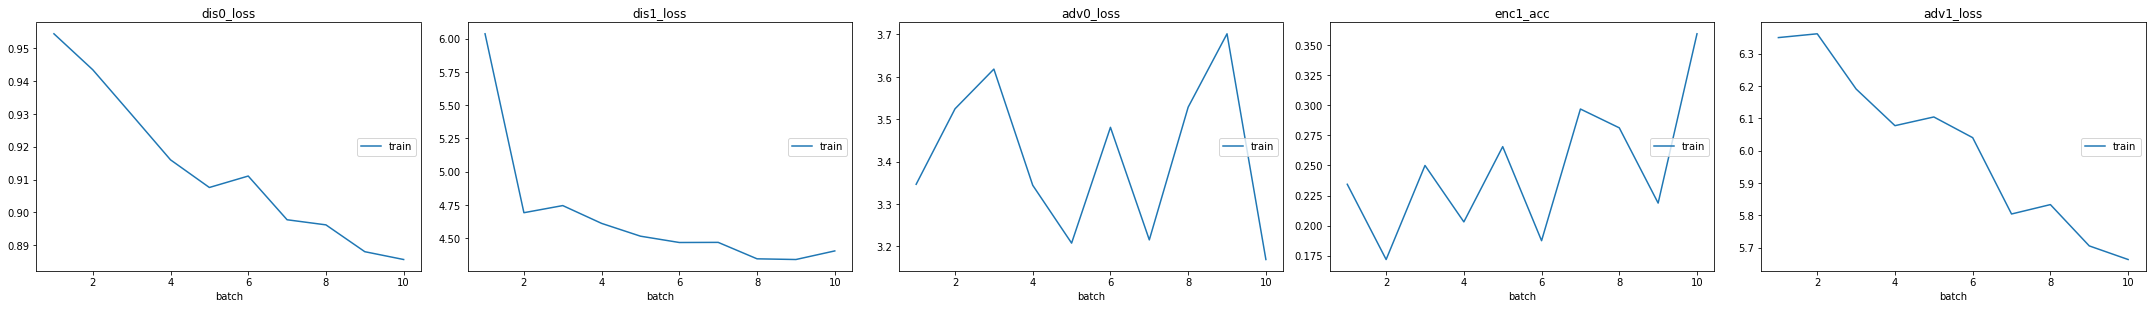

In [0]:
from tensorflow.keras.models import load_model

"""the original model used 2000 steps, here I just load a small number of steps
to highlight the process, and get the model archetecture to load the weights into..
..if you want to retrain the model add more steps than 10 and don't load the weights. 
"""
steps = 10 # original model used 2000 (choose a low number if you)
gen0, gen1 = build_and_train_models(train_steps = steps)

# Comment and uncomment to load/save models
# gen1.save("gen0")
# gen0.save_weights("gen1_weights")

## Load the fully developed model.

gen0 = load_model("gen0")
gen1.load_weights('gen1_weights')

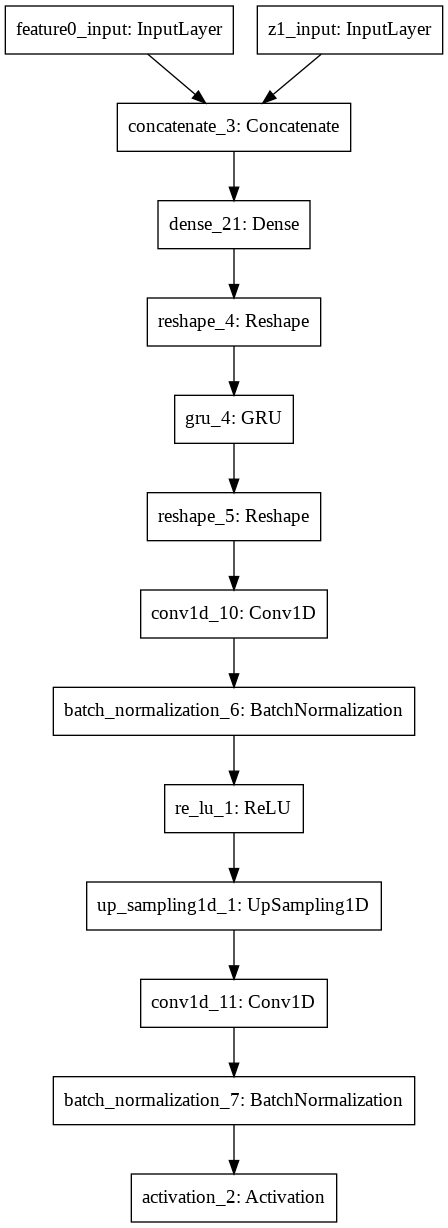

In [0]:
import tensorflow as tf 

tf.keras.utils.plot_model(
    gen1, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)


Create A Few Latent Code Recipes

1. Class 0 (-10% return condition)
1. Class 5 (+10% return condition)
1. Non-stratified noise class (noisy return condition)
1. Value 4 z-0 noise replacement + noise class
1. Value 4 z-1 noise replacement + noise class

In [0]:
def create_latent(dataX, batch_n = 1000, equal_batch=True, class_dim = 6, class_label = 4, z_dim = 50,z_val = 4, classed=True, noise="Normal" ):
  if classed==True:
    new = dataX[dataX[:,:,6] == class_label]
    new = np.reshape(new,(int(len(new)/24), 24, 7))[:,:,:-1]
    batch_num = new.shape[0]
    if not equal_batch:
      batch_num = batch_n
    print(batch_n)
    noise_class = np.zeros((batch_num, class_dim))
    noise_class[:,class_label] = 1
  else:
    noise_class = np.eye(class_dim)[np.random.choice(class_dim, batch_n)]
    new = dataX
    batch_num = batch_n
  if not equal_batch:
    batch_num = batch_n
  if noise=="Normal":
    z0 = np.random.normal(scale=0.5, size=[batch_num, z_dim])
    z1 = np.random.normal(scale=0.5, size=[batch_num, z_dim])
  elif noise=="z0_4":
    z0 = np.full((batch_num, z_dim), z_val)
    z1 = np.random.normal(scale=0.5, size=[batch_num, z_dim])
  elif noise=="z1_4":
    z0 = np.random.normal(scale=0.5, size=[batch_num, z_dim])
    z1 = np.full((batch_num, z_dim), z_val)

  return new, noise_class, z0, z1

d_recipe = {}
d_recipe["class0"] = [0, True, "Normal"]
d_recipe["class5"] = [5, True, "Normal"]
d_recipe["noise"] = [None, False, "Normal"]
d_recipe["z0_4"] = [None, False, "z0_4"]
d_recipe["z1_4"] = [None, False, "z1_4"]
d_recipe["org"] = d_recipe["noise"]


Let's Test 5 Latent Code Recipes. 

In [0]:
%%capture
!pip install datagene
!pip install git+git://github.com/FirmAI-Research/ecopy.git

In [0]:
from datagene import distance as dist
from datagene import transform as tran
from datagene import mod_utilities as mod
from datagene import dist_utilities as distu
from datagene import vis_utilities as visu

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Here is where I generated the visualisations for similarity comparison, and calculated the utility metrics. Run ```viz = ["preds"]``` for the utility metrics, run ```viz = ["autocorr", "featcorr","timecorr", "tsna", "pca", "mean_vol","mean_price", "var_vol", "var_price", "gaf", "gafts", "gram4d", "pairrec", "recplot", "mtf", "mtf3d"]``` for the similarity visualisations.

1000
(32, 1)
Epoch 1/40
200/200 [==============================] - 1s 7ms/step - loss: 0.1300 - val_loss: 0.0307
Epoch 2/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0385 - val_loss: 0.0256
Epoch 3/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0328 - val_loss: 0.0244
Epoch 4/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0317 - val_loss: 0.0247
Epoch 5/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0311 - val_loss: 0.0248
Epoch 6/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0307 - val_loss: 0.0237
Epoch 7/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0310 - val_loss: 0.0239
Epoch 8/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0299 - val_loss: 0.0234
Epoch 9/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0304 - val_loss: 0.0244
Epoch 10/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0302 - val

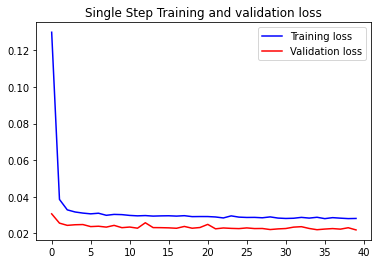

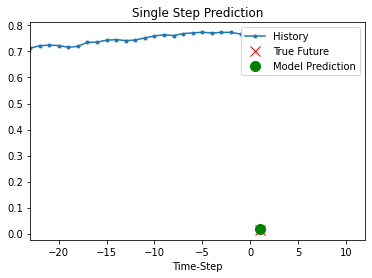

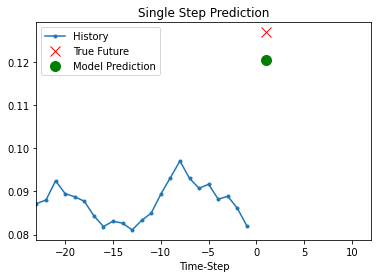

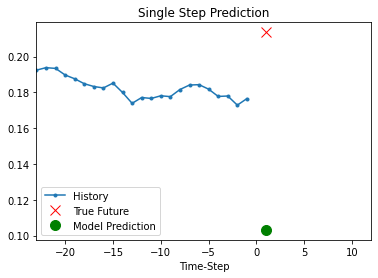

0.02234300279967317
1000
(32, 1)
Epoch 1/40
200/200 [==============================] - 2s 8ms/step - loss: 0.1337 - val_loss: 0.0333
Epoch 2/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0396 - val_loss: 0.0275
Epoch 3/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0335 - val_loss: 0.0266
Epoch 4/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0322 - val_loss: 0.0290
Epoch 5/40
200/200 [==============================] - 1s 7ms/step - loss: 0.0316 - val_loss: 0.0240
Epoch 6/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0307 - val_loss: 0.0276
Epoch 7/40
200/200 [==============================] - 1s 5ms/step - loss: 0.0306 - val_loss: 0.0267
Epoch 8/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0305 - val_loss: 0.0233
Epoch 9/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0303 - val_loss: 0.0235
Epoch 10/40
200/200 [==============================] - 1s 6ms/step 

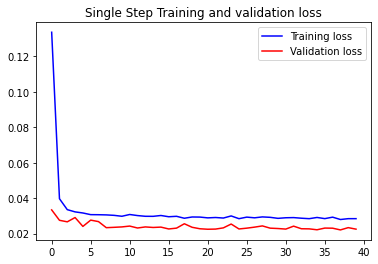

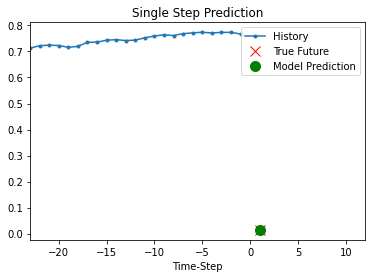

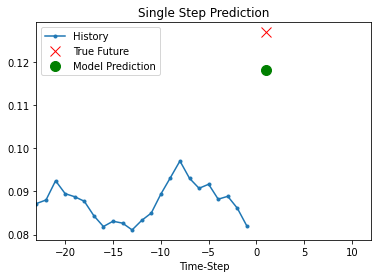

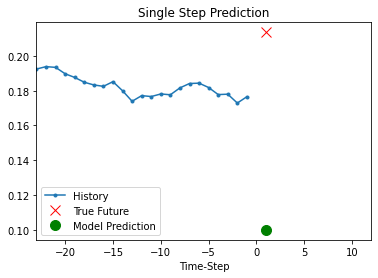

0.022852507736183605
(32, 1)
Epoch 1/40
200/200 [==============================] - 2s 8ms/step - loss: 0.1203 - val_loss: 0.0361
Epoch 2/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0402 - val_loss: 0.0277
Epoch 3/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0353 - val_loss: 0.0260
Epoch 4/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0336 - val_loss: 0.0263
Epoch 5/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0327 - val_loss: 0.0251
Epoch 6/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0310 - val_loss: 0.0247
Epoch 7/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0314 - val_loss: 0.0261
Epoch 8/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0310 - val_loss: 0.0234
Epoch 9/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0308 - val_loss: 0.0240
Epoch 10/40
200/200 [==============================] - 1s 6ms/step - lo

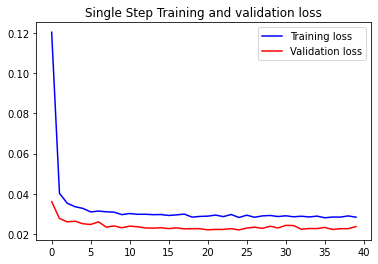

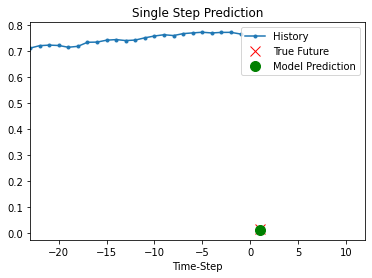

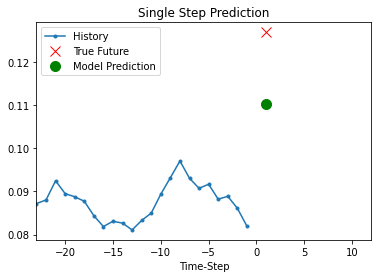

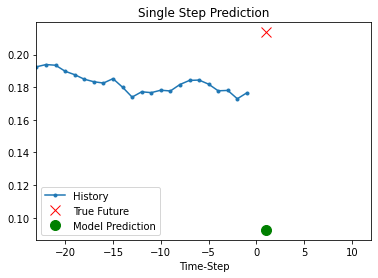

0.024032360951578607
(32, 1)
Epoch 1/40
200/200 [==============================] - 1s 7ms/step - loss: 0.1369 - val_loss: 0.0374
Epoch 2/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0399 - val_loss: 0.0258
Epoch 3/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0339 - val_loss: 0.0283
Epoch 4/40
200/200 [==============================] - 1s 5ms/step - loss: 0.0323 - val_loss: 0.0283
Epoch 5/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0315 - val_loss: 0.0280
Epoch 6/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0309 - val_loss: 0.0253
Epoch 7/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0313 - val_loss: 0.0260
Epoch 8/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0303 - val_loss: 0.0247
Epoch 9/40
200/200 [==============================] - 1s 7ms/step - loss: 0.0308 - val_loss: 0.0245
Epoch 10/40
200/200 [==============================] - 1s 6ms/step - lo

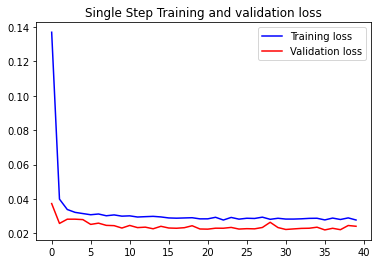

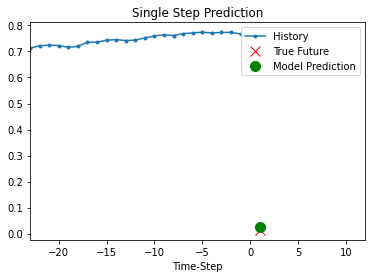

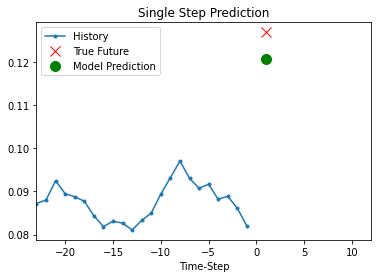

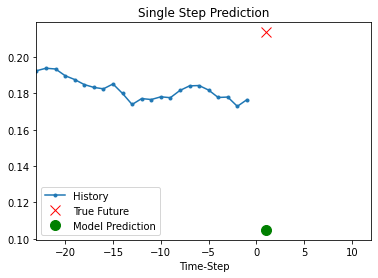

0.024658562412652445
(32, 1)
Epoch 1/40
200/200 [==============================] - 2s 11ms/step - loss: 0.1246 - val_loss: 0.0336
Epoch 2/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0408 - val_loss: 0.0306
Epoch 3/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0356 - val_loss: 0.0275
Epoch 4/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0333 - val_loss: 0.0263
Epoch 5/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0327 - val_loss: 0.0256
Epoch 6/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0317 - val_loss: 0.0247
Epoch 7/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0315 - val_loss: 0.0246
Epoch 8/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0312 - val_loss: 0.0255
Epoch 9/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0308 - val_loss: 0.0240
Epoch 10/40
200/200 [==============================] - 1s 6ms/step - l

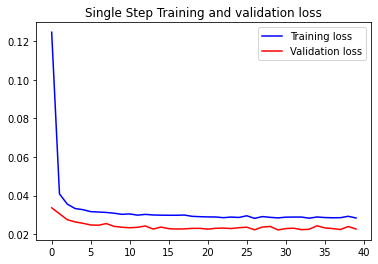

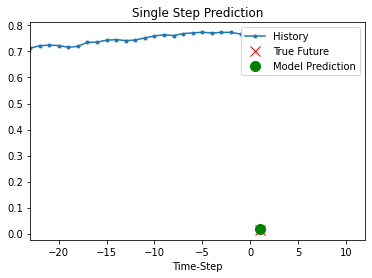

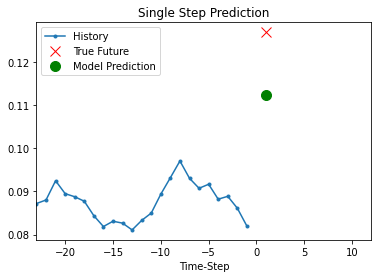

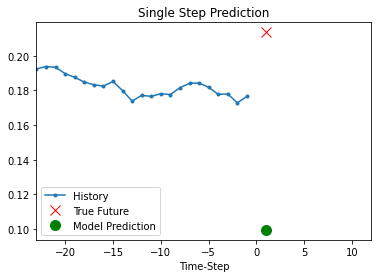

0.023075318498131877
(32, 1)
Epoch 1/40
200/200 [==============================] - 2s 9ms/step - loss: 0.1145 - val_loss: 0.0297
Epoch 2/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0378 - val_loss: 0.0278
Epoch 3/40
200/200 [==============================] - 1s 5ms/step - loss: 0.0339 - val_loss: 0.0251
Epoch 4/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0324 - val_loss: 0.0248
Epoch 5/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0318 - val_loss: 0.0269
Epoch 6/40
200/200 [==============================] - 1s 7ms/step - loss: 0.0316 - val_loss: 0.0258
Epoch 7/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0307 - val_loss: 0.0250
Epoch 8/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0312 - val_loss: 0.0239
Epoch 9/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0312 - val_loss: 0.0245
Epoch 10/40
200/200 [==============================] - 1s 6ms/step - lo

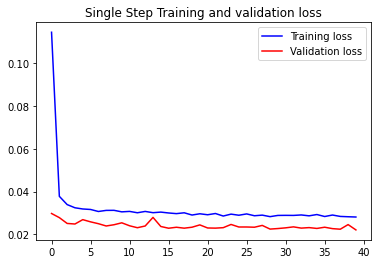

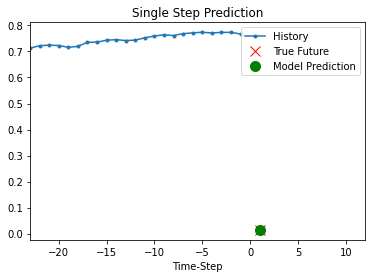

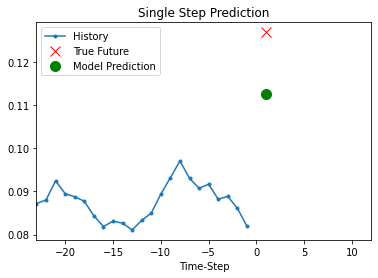

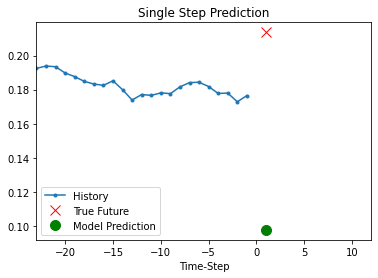

0.022507598089036022


In [0]:
import statsmodels.api as sm
nlags = 13 #for the autocorrelation chart

def plot_corr(df):
  f = plt.figure(figsize=(5, 5))
  plt.matshow(df, fignum=f.number)
  plt.xticks(range(df.shape[1]), df.columns, fontsize=5, rotation=45)
  plt.yticks(range(df.shape[1]), df.columns, fontsize=5)
  cb = plt.colorbar()
  cb.ax.tick_params(labelsize=5)
  plt.title('Correlation Matrix', fontsize=16);

def inverse_trans(train_data):
  num_instances, num_time_steps, num_features = train_data.shape
  train_data = np.reshape(train_data, (-1, num_features))
  train_data = scaler.inverse_transform(train_data)
  train_data = np.reshape(train_data, (num_instances, num_time_steps, num_features))
  return train_data

viz = ["autocorr", "featcorr","timecorr", "tsna", "pca", "mean_vol","mean_price", "var_vol", "var_price", "gaf", "gafts", "gram4d", "pairrec", "recplot", "mtf", "mtf3d"]
## runs for about 8 minutes
viz = ["preds"]
preds = {}
for typed in viz:
  for en, key in enumerate(d_recipe.keys()):
    new, noise_class, z0, z1 = create_latent(dataX, class_label = d_recipe[key][0], classed=d_recipe[key][1], noise=d_recipe[key][2])
    feature0 = gen0.predict([noise_class, z1])
    gen_data = gen1.predict([feature0, z0])
    gen_data_t = inverse_trans(gen_data)
    if key=='org':
      df = new
    else:
      df = gen_data
    if typed=="autocorr":
      sm.graphics.tsa.plot_acf(df.mean(axis=0)[:,0], lags=nlags)
      plt.show()
    if typed=="featcorr":
      corr_1 = pd.DataFrame(df.mean(0)).corr()
    if typed=="timecorr":
      corr_1 = pd.DataFrame(df.mean(0).T).corr()
      plot_corr(corr_1)
    if typed=="tsna":
      tSNE_Analysis(new, df)
    if typed=="pca":
      PCA_Analysis(new, df)
    if typed=="mean_vol":
      plt.plot(df.mean(axis=0)[:,5],label=key)
      plt.legend()
    if typed=="mean_price":
      plt.plot(df.mean(axis=0)[:,4],label=key)
      plt.legend()
    if typed=="var_vol":
      plt.plot(df.var(axis=0)[:,5],label=key)
      plt.legend()
    if typed=="var_price":
      plt.plot(df.var(axis=0)[:,4],label=key)
      plt.legend()
    if typed=="gaf":
      gaf_sff_3d_org, gaf_fss_3d_org = tran.gaf_encode_mat(df.mean(axis=0))
      images = [gaf_fss_3d_org[4], gaf_fss_3d_org[5]]
      titles = ['Closing', 'Volume']
      visu.multi_plot(images, titles, 'Gramian Angular Fields')
    if typed=="gafts":
      gaf_sff_3d_org, gaf_fss_3d_org = tran.gaf_encode_mat(df.mean(axis=0))
      images = [gaf_sff_3d_org[4], gaf_sff_3d_org[5]]
      titles = ['TS 4', 'TS 5' ]
      visu.multi_plot(images, titles, 'Gramian Angular Fields')
    if typed=="gram4d":
      gaf_isff_4d_org  = tran.gaf_encode_3_to_4([df])
      display(visu.array_4d_to_rgba_image(next(gaf_isff_4d_org), transpose=True))
    if typed=="pairrec": 
      ds = [np.var(array,axis=0) for array in [df]]
      list_names = ["Original"]
      visu.three_plots(ds,list_names)
    if typed=="recplot":
      mpr_isff_4d_org = tran.mrp_encode_3_to_4([df]) 
      display(visu.array_4d_to_rgba_image(next(mpr_isff_4d_org),swap=(0,2)))
    if typed=="mtf":
      mtf_fsdd_4d_org = tran.mtf_encode_3_to_4([df])
      display(visu.array_4d_to_rgba_image(next(mtf_fsdd_4d_org)))
    if typed=="mtf3d":
      ds = [np.mean(array,axis=0) for array in [df]]
      mtf_fdd_3d_org = tran.mtf_encode_2_to_3(ds)
      display(visu.array_3d_to_rgb_image(next(mtf_fdd_3d_org).T))
    if typed=="preds":
      new, noise_class, z0, z1 = create_latent(dataX, equal_batch=False, class_label = d_recipe[key][0], classed=False, noise=d_recipe[key][2])
      feature0 = gen0.predict([noise_class, z1])
      gen_data = gen1.predict([feature0, z0])
      single_step_model_gen_1, y_pred_gen_1, org_y_vl, org_y_vl_m1 = mod.model_output_cross(new, df,epochs=40) #actuall outperforms the original model (500 iterations)
      preds[key] = y_pred_gen_1


In [0]:
pred_dict = dist.regression_metrics(pred_list=[preds["org"],preds["class0"],preds["class5"],preds["noise"],preds["z0_4"],preds["z1_4"],org_y_vl_m1],name_list=["original",'class0', 'class5', 'noise', 'z0_4', 'z1_4',"previous day"],valid=org_y_vl)

Because of the nature of these models these values change, the best strategy is to run the predictions 10-20 times and then report the average and standard deviation. This is time consuming, so I did not do it here. But what we generally find is that the model performance of the generated data is very close to that of the original data. I ran the model twice, to show some of the deviation.

In [0]:
pd.DataFrame.from_dict(pred_dict)

,original,class0,class5,noise,z0_4,z1_4,previous day
explained_variance_score,0.591786,0.617014,0.529690,0.520578,0.551472,0.511540,0.692531
max_error,0.648139,0.636237,0.644434,0.664099,0.639325,0.658607,0.618938
mean_absolute_error,0.022508,0.022343,0.022853,0.024032,0.024659,0.023075,0.025106
mean_squared_error,0.002465,0.002347,0.002592,0.002726,0.002411,0.002563,0.002668
mean_squared_log_error,0.001442,0.001368,0.001520,0.001619,0.001411,0.001500,0.001559
median_absolute_error,0.008191,0.008427,0.008037,0.009304,0.012900,0.009454,0.010191
r2_score,0.578387,0.611442,0.503470,0.465801,0.551195,0.492474,0.692196


In [0]:
pd.DataFrame.from_dict(pred_dict)

,original,class0,class5,noise,z0_4,z1_4,previous day
explained_variance_score,0.603212,0.550718,0.558250,0.594933,0.584677,0.432169,0.692531
max_error,0.636409,0.650359,0.654596,0.653708,0.638975,0.675791,0.618938
mean_absolute_error,0.022559,0.022635,0.022712,0.022799,0.022846,0.023684,0.025106
mean_squared_error,0.002359,0.002507,0.002520,0.002519,0.002395,0.002799,0.002668
mean_squared_log_error,0.001379,0.001466,0.001467,0.001470,0.001397,0.001644,0.001559
median_absolute_error,0.008637,0.008582,0.008949,0.008256,0.009585,0.008903,0.010191
r2_score,0.597965,0.532402,0.546948,0.584821,0.579522,0.393170,0.692196


Clustering

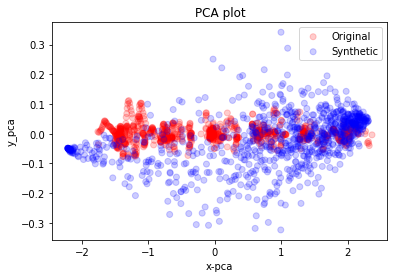

In [0]:
PCA_Analysis(new, gen_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1800 samples in 0.009s...
[t-SNE] Computed neighbors for 1800 samples in 0.064s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1800
[t-SNE] Computed conditional probabilities for sample 1800 / 1800
[t-SNE] Mean sigma: 0.056627
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.182167
[t-SNE] KL divergence after 300 iterations: 0.625763


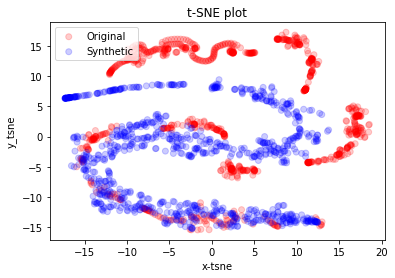

In [0]:
tSNE_Analysis(new, gen_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1034 samples in 0.002s...
[t-SNE] Computed neighbors for 1034 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1034
[t-SNE] Computed conditional probabilities for sample 1034 / 1034
[t-SNE] Mean sigma: 0.044431
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.749454
[t-SNE] KL divergence after 300 iterations: 0.454175


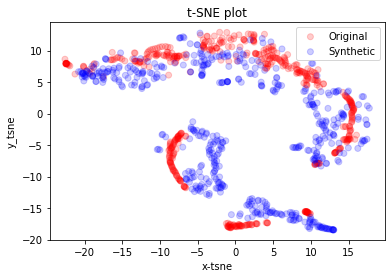

In [0]:
tSNE_Analysis(new, gen_data)

Esteban, C., Hyland, S. L., & Rätsch, G. (2017). Real-valued (medical) time series generation with recurrent conditional gans. ArXiv Preprint ArXiv:1706.02633.

Fu, R., Chen, J., Zeng, S., Zhuang, Y., & Sudjianto, A. (2019). Time Series Simulation by Conditional Generative Adversarial Net. ArXiv Preprint ArXiv:1904.11419.

Huang, X., Li, Y., Poursaeed, O., Hopcroft, J., & Belongie, S. (2017). Stacked generative adversarial networks. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, 5077–5086.

Mirza, M., & Osindero, S. (2014). Conditional generative adversarial nets. ArXiv Preprint ArXiv:1411.1784.

Yoon, J., Jarrett, D., & van der Schaar, M. (2019). Time-series Generative Adversarial Networks. Advances in Neural Information Processing Systems, 5509–5519.
 
